In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
# import albumentations as A
import pytorch_lightning as pl
import time

from torchsummary import summary
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from sklearn.model_selection import train_test_split
# from albumentations.pytorch.transforms import ToTensorV2

import transforms as T
import utils

In [2]:
# TORCH_DEVICE = 'mps' # there is currently a bug: https://github.com/pytorch/pytorch/issues/78915
TORCH_DEVICE = 'cpu'
CKPT_PATH = './pre_trained_models/EfficientnetB0_grayscale/'
# CKPT_NAME = 'epoch=17-step=2808.ckpt'
CKPT_NAME = 'epoch=18-step=2964.ckpt'

DATA_PATH = '../RPN_Backbone_GZ2/Data/'
IMAGE_PATH = DATA_PATH + 'real_pngs/'

LOG_DIR = './models/Zoobot/train'

# using typical split of 80:10:10
SIZE_OF_VALIDATION_SET = 0.2
SIZE_OF_TEST_SET = 0.1

BATCH_SIZE = 32
CUTOUT = (50, 50, 350, 350)
CUTOUT_ARRAY = np.array([50, 350, 50, 350])

In [38]:
# create dataframe for image annotations
# loading metadata
file_path1 = DATA_PATH + 'combined_cat.pkl'
file_path2 = DATA_PATH + 'zoo2LocalIdMap.pkl'

df_combined_cat = (pd
    .read_pickle(file_path1)
    #.reset_index() 
    #.explode('false_pos_prob_stats')
)

zooToLocal = pd.read_pickle(file_path2)
df_combined_cat['local_ids'] = zooToLocal.loc[df_combined_cat.index.get_level_values(0)].to_numpy()

df_combined_cat.reset_index(inplace=True)

# Filter out any bulge markings that snuck through
is_central = (
    np.abs(0.5*(df_combined_cat['x2_normed'] + df_combined_cat['x1_normed']) - 0.5) < 0.02
    ) & (
    np.abs(0.5*(df_combined_cat['y2_normed'] + df_combined_cat['y1_normed']) - 0.5) < 0.02
    )

df_combined_cat = df_combined_cat.loc[~is_central | df_combined_cat['empty']].copy()

# reduct to only samples with objects
df_combined_cat = df_combined_cat[~df_combined_cat['empty']]

# stick to sizes used for Zoobot training
cutout = CUTOUT_ARRAY
cutout_normed = CUTOUT_ARRAY/400

# Convert x/y normed
pad = 0.05
selector = (
    df_combined_cat['x1_normed'] > cutout_normed[0] + pad
    ) & (
    df_combined_cat['x2_normed'] < cutout_normed[1] - pad
    ) & (
    df_combined_cat['y1_normed'] > cutout_normed[2] + pad
    ) & (
    df_combined_cat['y2_normed'] < cutout_normed[3] - pad
    )

def convert_x_normed(x_normed):
    x_normed = (x_normed - cutout_normed[0]) / (cutout_normed[1] - cutout_normed[0])
    return x_normed

def convert_y_normed(y_normed):
    y_normed = (y_normed - cutout_normed[2]) / (cutout_normed[3] - cutout_normed[2])
    return y_normed

df_combined_cat['x1_normed'] = df_combined_cat.apply(lambda x: convert_x_normed(x['x1_normed']), axis=1)
df_combined_cat['x2_normed'] = df_combined_cat.apply(lambda x: convert_x_normed(x['x2_normed']), axis=1)
df_combined_cat['y1_normed'] = df_combined_cat.apply(lambda y: convert_y_normed(y['y1_normed']), axis=1)
df_combined_cat['y2_normed'] = df_combined_cat.apply(lambda y: convert_y_normed(y['y2_normed']), axis=1)

df_combined_cat['x1'] = df_combined_cat['x1_normed'] * (cutout[1] - cutout[0])
df_combined_cat['x2'] = df_combined_cat['x2_normed'] * (cutout[1] - cutout[0])
df_combined_cat['y1'] = df_combined_cat['y1_normed'] * (cutout[3] - cutout[2])
df_combined_cat['y2'] = df_combined_cat['y2_normed'] * (cutout[3] - cutout[2])

# Check, if image exists
df_combined_cat['filename'] = IMAGE_PATH + df_combined_cat['local_ids'].apply(str) + '.png'
df_combined_cat['file_exists'] = (df_combined_cat['filename']).apply(os.path.exists)

# labels
# 0 - background
# 1 - Clump 
# 2 - Odd Clump
# 3 - Improbable Clump
# 4 - Odd Improbable Clump
df_combined_cat['is_odd'] = np.where(df_combined_cat['mean_tool'] > 0.5, True, False)
df_combined_cat['is_improbable'] = np.where(df_combined_cat['false_pos_prob'] > 0.7, True, False)

df_combined_cat['label'] = np.select(
    [
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
    ], 
    [
        1,
        2,
        2, #3
        2, #4
    ],
    default = None
)

df_combined_cat['label_text'] = np.select(
    [
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
    ], 
    [
        b'clumpy',
        b'clumpy, odd',
        b'clumpy, odd', # b'clumpy, improbable',
        b'clumpy, odd', # b'clumpy, odd and improbable',
    ],
    default = ''
)

# get train and validation samples
unique_ids = df_combined_cat[df_combined_cat['file_exists']]['image_id'].unique()
unique_ids = unique_ids[:500] # for prototyping

train_ids, val_ids = train_test_split(unique_ids, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET, random_state=42)
df_combined_cat = df_combined_cat[df_combined_cat['file_exists']]

df_combined_cat = df_combined_cat[
    ['image_id', 'local_ids', 'filename', 'label', 'label_text',
    # 'x1_normed', 'x2_normed', 'y1_normed', 'y2_normed']
    'x1', 'x2', 'y1', 'y2']
]

imageGroups_train = df_combined_cat[df_combined_cat['image_id'].isin(train_ids)]
imageGroups_valid = df_combined_cat[df_combined_cat['image_id'].isin(val_ids)]

imageGroups_train = imageGroups_train.set_index(['image_id', 'local_ids', 'filename', 'label'])
imageGroups_valid = imageGroups_valid.set_index(['image_id', 'local_ids', 'filename', 'label'])

imageGroups_train.reset_index(inplace=True)
imageGroups_valid.reset_index(inplace=True)

epochs = 80
print('Size of train-set: {}, Size of validation-set: {}'.format(len(imageGroups_train),len(imageGroups_valid)))
print('So, for {} epochs we need {} steps.'.format(epochs, (len(imageGroups_train)+len(imageGroups_valid)/BATCH_SIZE*epochs)))
# print('Train with Objects: {}, Train w/o objects: {}'.format(len(df_train), len(df_train_empty)))
# print('Validation with Objects: {}, Validation w/o objects: {}'.format(len(df_val), len(df_val_empty)))

Size of train-set: 32270, Size of validation-set: 13894
So, for 80 epochs we need 67005.0 steps.


In [37]:
# saving dfs
imageGroups_train.to_pickle('imageGroups_train.pkl')
imageGroups_valid.to_pickle('imageGroups_valid.pkl')
imageGroups_train.to_csv('imageGroups_train.csv')
imageGroups_valid.to_csv('imageGroups_valid.csv')

In [10]:
# initialise Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $LOG_DIR

In [3]:
# read train and validation dfs
# imageGroups_train = pd.read_csv('./imageGroups_train.csv')
# imageGroups_valid = pd.read_csv('./imageGroups_valid.csv')
imageGroups_train = pd.read_pickle('./imageGroups_train.pkl')
imageGroups_valid = pd.read_pickle('./imageGroups_valid.pkl')

In [4]:
def get_transform(train):
    augs = []

    augs.append(T.PILToTensor())
    augs.append(T.ConvertImageDtype(torch.float))
    
    if train:
        augs.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(augs)

In [5]:
# Dataset class and defined transformations
import SDSSGalaxyDataset

dataset_train = SDSSGalaxyDataset.SDSSGalaxyDataset(
    dataframe=imageGroups_train,
    image_dir=IMAGE_PATH,
    cutout=CUTOUT,
    transforms=get_transform(train=True)
)
dataset_validation = SDSSGalaxyDataset.SDSSGalaxyDataset(
    dataframe=imageGroups_valid,
    image_dir=IMAGE_PATH,
    cutout=CUTOUT,
    transforms=get_transform(train=False)
)

train_data_loader = torch.utils.data.DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    collate_fn=utils.collate_fn
)
valid_data_loader = torch.utils.data.DataLoader(
    dataset_validation, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    collate_fn=utils.collate_fn
)

print("Count: {} are training and {} validation".format(len(dataset_train), len(dataset_validation)))

Count: 2442 are training and 1046 validation


In [6]:
images, targets = next(iter(train_data_loader))
images = list(image.to(TORCH_DEVICE) for image in images)
targets = [{k: v.to(TORCH_DEVICE) for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


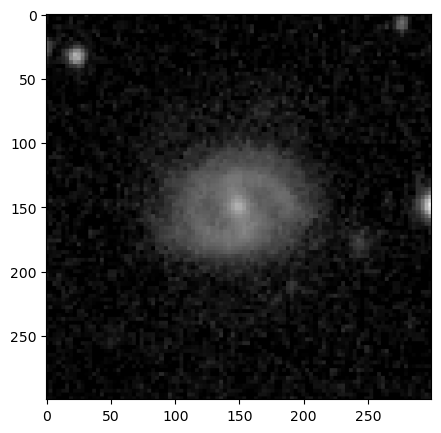

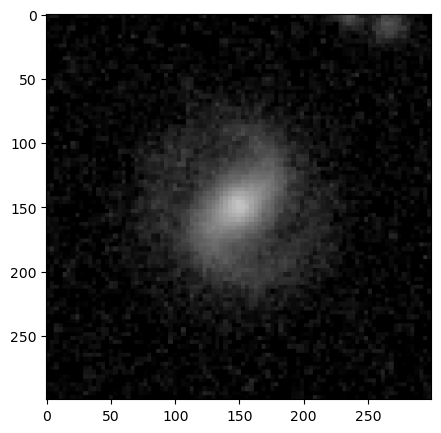

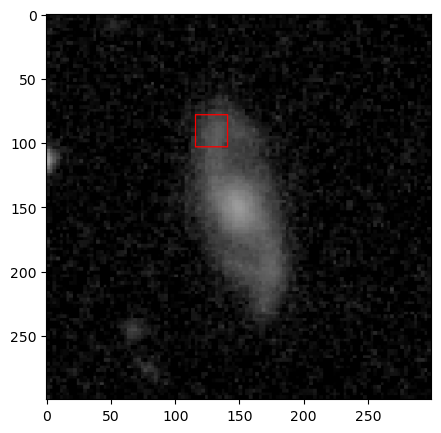

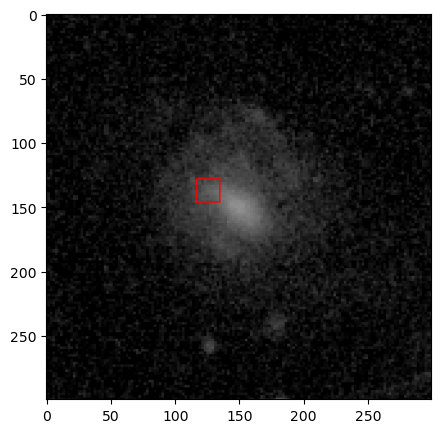

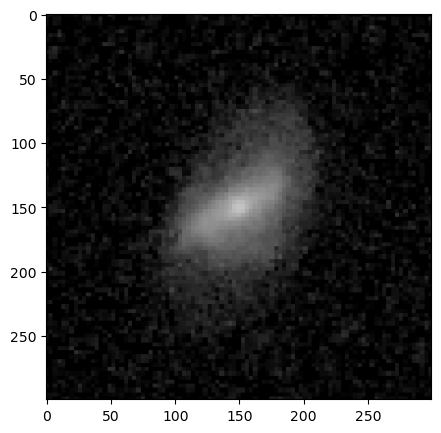

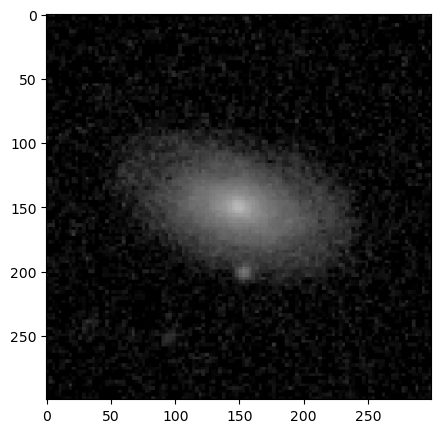

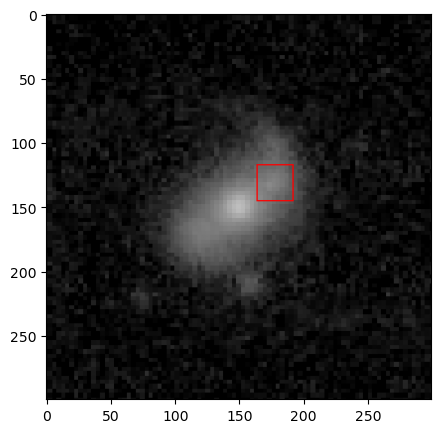

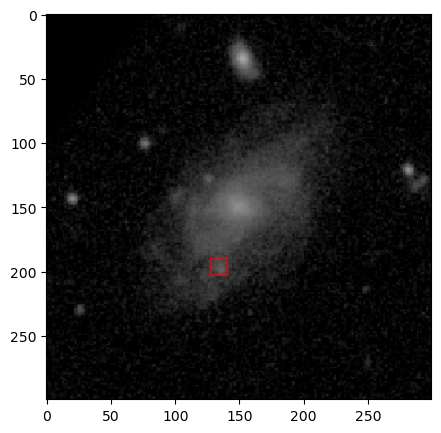

In [7]:
for i in range(8):
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(5, 5))
    sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
    
    for box in boxes:
        cv2.rectangle(sample,  # the image is in RGB, convert to BGR for cv2 annotations
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 255), 1)
    plt.imshow(sample[:, :, ::-1])
    # plt.axis('off')

In [8]:
def create_model():
    # Get Zoobot model and weights
    import define_model
    zoobot = define_model.ZoobotLightningModule(
        output_dim=34,
        question_index_groups=['idx1', 'idx2'],
        include_top=True,
        channels=1,
        use_imagenet_weights=False,
        always_augment=True,
        dropout_rate=0.2,
    )
    checkpoint = torch.load(CKPT_PATH+CKPT_NAME, map_location=torch.device(TORCH_DEVICE))
    zoobot.load_state_dict(checkpoint['state_dict'])
    
    # select layers for feature map
    conv_stem = torch.nn.Sequential(zoobot.model[0].features[0])
    blocks = torch.nn.Sequential(zoobot.model[0].features[1:8])
    conv_head = torch.nn.Sequential(zoobot.model[0].features[8])

    backbone = torch.nn.Sequential(conv_stem, blocks, conv_head)
    backbone.out_channels = 1280

    # anchor_generator = AnchorGenerator(
    #     sizes=((4, 8, 16, 32, 64),), 
    #     aspect_ratios=((0.75, 1.0, 1.25),)
    # )
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    # Feature maps to perform RoI cropping.
    # If backbone returns a Tensor, `featmap_names` is expected to
    # be [0]. We can choose which feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], 
        output_size=7,
        sampling_ratio=2
    )

    # put everything together (https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L256)
    model = FasterRCNN(
        backbone, 
        num_classes=3,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    # adjust to ensure we have only 1 channel
    # Changes
    grcnn = GeneralizedRCNNTransform(
        min_size=200,
        max_size=400,
        image_mean=[0.485], 
        image_std=[0.229]
    )
    model.transform = grcnn

    # freeze all bn layers
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.eval()

    return model

In [1]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
    return model

In [9]:
# Training
NUM_EPOCHS = 70

# get the model
frcnn_model = create_model() # get_model(num_classes=3)

# move model to the right device
frcnn_model = frcnn_model.to(TORCH_DEVICE)

# construct an optimizer
params = [p for p in frcnn_model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/opt/homebrew/Caskroom/miniforge/base/envs/env_torch/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [10]:
from engine import train_one_epoch, evaluate

for epoch in range(NUM_EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(
        frcnn_model, 
        optimizer, 
        train_data_loader, 
        TORCH_DEVICE, 
        epoch, 
        print_freq=10,
        scaler=None,
        # tb_writer=writer
        tb_writer=None
    )
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(
        frcnn_model, 
        valid_data_loader, 
        device=TORCH_DEVICE
    )

Epoch: [0]  [ 0/77]  eta: 1:23:07  lr: 0.000014  loss: 1.8359 (1.8359)  loss_classifier: 1.1328 (1.1328)  loss_box_reg: 0.0001 (0.0001)  loss_objectness: 0.6958 (0.6958)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 64.7769  data: 3.3732
Epoch: [0]  [10/77]  eta: 1:10:36  lr: 0.000146  loss: 0.8517 (0.9517)  loss_classifier: 0.2371 (0.4002)  loss_box_reg: 0.0011 (0.0011)  loss_objectness: 0.6051 (0.5431)  loss_rpn_box_reg: 0.0079 (0.0073)  time: 63.2272  data: 0.3670
Epoch: [0]  [20/77]  eta: 0:58:56  lr: 0.000277  loss: 0.2940 (0.5909)  loss_classifier: 0.0910 (0.2491)  loss_box_reg: 0.0016 (0.0016)  loss_objectness: 0.2542 (0.3329)  loss_rpn_box_reg: 0.0077 (0.0073)  time: 61.8995  data: 0.0423
Epoch: [0]  [30/77]  eta: 1:10:48  lr: 0.000408  loss: 0.1224 (0.4326)  loss_classifier: 0.0704 (0.1909)  loss_box_reg: 0.0021 (0.0018)  loss_objectness: 0.0288 (0.2332)  loss_rpn_box_reg: 0.0061 (0.0067)  time: 105.3476  data: 0.0140
Epoch: [0]  [40/77]  eta: 0:50:47  lr: 0.000540  loss: 0.0649 (

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/33]  eta: 0:04:47  model_time: 6.9403 (6.9403)  evaluator_time: 0.0094 (0.0094)  time: 8.7054  data: 1.7556
Test:  [32/33]  eta: 0:00:06  model_time: 6.8803 (6.7902)  evaluator_time: 0.0069 (0.0073)  time: 6.7952  data: 0.0054
Test: Total time: 0:04:06 (7.4641 s / it)
Averaged stats: model_time: 6.8803 (6.7902)  evaluator_time: 0.0069 (0.0073)
Accumulating evaluation results...
DONE (t=0.39s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/33]  eta: 0:04:59  model_time: 7.5445 (7.5445)  evaluator_time: 0.0067 (0.0067)  time: 9.0889  data: 1.5376
Test:  [32/33]  eta: 0:00:07  model_time: 7.3558 (7.3049)  evaluator_time: 0.0048 (0.0057)  time: 7.2720  data: 0.0057
Test: Total time: 0:04:23 (7.9703 s / it)
Averaged stats: model_time: 7.3558 (7.3049)  evaluator_time: 0.0048 (0.0057)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/33]  eta: 0:04:52  model_time: 7.3538 (7.3538)  evaluator_time: 0.0046 (0.0046)  time: 8.8527  data: 1.4941
Test:  [32/33]  eta: 0:00:07  model_time: 7.1969 (7.1466)  evaluator_time: 0.0040 (0.0043)  time: 7.1134  data: 0.0063
Test: Total time: 0:04:17 (7.8099 s / it)
Averaged stats: model_time: 7.1969 (7.1466)  evaluator_time: 0.0040 (0.0043)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/33]  eta: 0:05:04  model_time: 7.5917 (7.5917)  evaluator_time: 0.0056 (0.0056)  time: 9.2247  data: 1.6273
Test:  [32/33]  eta: 0:00:07  model_time: 7.3914 (7.3567)  evaluator_time: 0.0026 (0.0033)  time: 7.3123  data: 0.0056
Test: Total time: 0:04:24 (8.0227 s / it)
Averaged stats: model_time: 7.3914 (7.3567)  evaluator_time: 0.0026 (0.0033)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/33]  eta: 0:05:05  model_time: 7.5790 (7.5790)  evaluator_time: 0.0038 (0.0038)  time: 9.2650  data: 1.6821
Test:  [32/33]  eta: 0:00:07  model_time: 7.3687 (7.3246)  evaluator_time: 0.0030 (0.0031)  time: 7.2895  data: 0.0063
Test: Total time: 0:04:24 (8.0054 s / it)
Averaged stats: model_time: 7.3687 (7.3246)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max